In [1]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
import numpy as np 
from scipy import signal 
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

2023-12-30 19:05:02.249956: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-30 19:05:02.295041: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-30 19:05:02.295071: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-30 19:05:02.295095: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-30 19:05:02.303654: I tensorflow/core/platform/cpu_feature_g

In [2]:
x=np.load('../BraiNeoCare/Datasets/GAT/zenodo_data_consensus_4s_GAT.npy', mmap_mode='r')
y=np.load('../BraiNeoCare/Datasets/GAT/zenodo_labels_consensus_4s_GAT.npy', mmap_mode='r')

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [3]:
mean=x_train.mean()
std=x_train.std()
x_train=(x_train-mean)/std
x_test=(x_test-mean)/std

x_train=np.expand_dims(x_train,axis=-1)
x_test=np.expand_dims(x_test,axis=-1)

In [4]:
y_train=y_train.astype(np.float32)
y_test=y_test.astype(np.float32)

In [5]:
channel_names=["Fp1-T3","T3-O1","Fp1-C3","C3-O1","Fp2-C4","C4-O2","Fp2-T4","T4-O2","T3-C3","C3-Cz","Cz-C4","C4-T4"]
indices =[[r,i] for r,c1 in enumerate(channel_names) for i,c2 in enumerate(channel_names) if (c1.split("-")[0]==c2.split("-")[1] or c1.split("-")[1]==c2.split("-")[1] 
          or c1.split("-")[0]==c2.split("-")[0] or c1.split("-")[1]==c2.split("-")[0])]
adj=np.zeros((12,12))
for i in indices:
    adj[i[0]][i[1]]=1
adj=tf.constant(adj,dtype=tf.float32)

2023-12-30 19:06:54.795200: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14947 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:17:00.0, compute capability: 7.5
2023-12-30 19:06:54.795834: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 14946 MB memory:  -> device: 1, name: Quadro RTX 5000, pci bus id: 0000:73:00.0, compute capability: 7.5


In [19]:
class GATLayer(layers.Layer):
    def __init__(self,output_dim):
        super(GATLayer, self).__init__()
        self.output_dim = output_dim
        self.LeakyReLU = layers.LeakyReLU(alpha=0.2)
    
    def build(self, input_shape):
        self.W = self.add_weight(name='W',shape=(input_shape[-1], self.output_dim), initializer='random_normal',trainable=True)
        self.a = self.add_weight(name='a',shape=(2*self.output_dim, 1), initializer='random_normal',trainable=True)
    
    def call(self,input,adj):
        H= tf.matmul(input, self.W)
        h1=tf.tile(tf.expand_dims(H, axis=1), [1,12,1,1])
        h2=tf.tile(tf.expand_dims(H, axis=2), [1,1,12,1])
        result =tf.concat([h1 , h2], axis=-1)
        e=self.LeakyReLU(tf.squeeze(tf.matmul(result, self.a),axis=-1))
        zero_mat=-1e20*tf.zeros_like(e)
        msked_e=tf.where(adj==1,e,zero_mat)
        alpha=tf.nn.softmax(msked_e,axis=-1)
        HPrime=tf.matmul(alpha,H)
        return tf.nn.elu(HPrime)



Input= keras.Input(shape=(12,384,1)) 

x= layers.Conv2D(4,(1,5),activation='relu',padding='same')(Input)
x= layers.SpatialDropout2D(0.2)(x)
x= layers.Conv2D(8,(1,5),activation='relu',padding='same')(x)
# x= layers.concatenate([x,y])
x= layers.MaxPool2D((1,2))(x)
x= layers.BatchNormalization()(x)
x= layers.SpatialDropout2D(0.2)(x)

x= layers.Conv2D(16,(1,5),activation='relu',padding='same')(x)
x= layers.SpatialDropout2D(0.25)(x)
x= layers.Conv2D(32,(1,5),activation='relu',padding='same')(x)
# x= layers.concatenate([x,y])
x= layers.MaxPool2D((1,2))(x)
x= layers.BatchNormalization()(x)
x= layers.SpatialDropout2D(0.2)(x)

x= layers.Conv2D(8,(1,5),activation='relu',padding='same')(x)
x= layers.SpatialDropout2D(0.25)(x)
x= layers.Conv2D(8,(1,5),activation='relu',padding='same')(x)
# x= layers.add([x,y])
x= layers.MaxPool2D((1,2))(x)
x= layers.BatchNormalization()(x)
x= layers.SpatialDropout2D(0.2)(x)

x= layers.Conv2D(1,(1,5),activation='relu',padding='same')(x)
x= layers.SpatialDropout2D(0.25)(x)
x= layers.Conv2D(1,(1,5),activation='relu',padding='same')(x)
# x= layers.add([x,y])
x= layers.MaxPool2D((1,2))(x)

x= layers.Reshape((12,24))(x)

x= GATLayer(37)(x,adj)
x= GATLayer(32)(x,adj)
x= GATLayer(16)(x,adj)

x = layers.GlobalAveragePooling1D()(x)
# x = layers.Dropout(0.2)(x)
# x= layers.Dense(32,activation='relu')(x)
x = layers.Dense(16,activation='relu')(x)
# x = layers.Dropout(0.25)(x)
x = layers.Dense(1,activation='sigmoid')(x)

model = keras.Model(inputs=Input, outputs=x)

In [9]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 12, 384, 1)]      0         
                                                                 
 conv2d_16 (Conv2D)          (None, 12, 384, 4)        24        
                                                                 
 spatial_dropout2d (Spatial  (None, 12, 384, 4)        0         
 Dropout2D)                                                      
                                                                 
 conv2d_17 (Conv2D)          (None, 12, 384, 8)        168       
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 12, 192, 8)        0         
 g2D)                                                            
                                                                 
 batch_normalization_6 (Bat  (None, 12, 192, 8)        32  

In [20]:
optimizer=keras.optimizers.Adam(learning_rate=0.001,weight_decay=0.0001)
loss=keras.losses.BinaryFocalCrossentropy(from_logits=False,gamma=2,alpha=0.75,apply_class_balancing=True)
# loss=keras.losses.BinaryCrossentropy(from_logits=False)  
F1=keras.metrics.F1Score(threshold=0.5, name='F1', dtype=None) 
precall = keras.metrics.Precision()
recall = keras.metrics.Recall()
AUROC = keras.metrics.AUC(curve='ROC', name = 'AUROC')
AUPRC = keras.metrics.AUC(curve='PR', name = 'AUPRC')
model.compile(optimizer=optimizer,loss=loss,metrics=['accuracy',F1, AUROC, AUPRC, precall, recall])    

In [21]:
# checkpoint_path = "GAT_model/cp_{epoch:04d}.ckpt"
# checkpoint_dir = os.path.dirname(checkpoint_path) 
# cp_callback=keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,save_weights_only=True,verbose=0,save_best_only=True,monitor='val_accuracy')  
history=model.fit(x_train,y_train,epochs=200,batch_size=256,verbose=1,validation_data=(x_test,y_test))#,callbacks=[cp_callback])

Epoch 1/200


2023-12-30 21:36:47.965317: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_5/spatial_dropout2d_21/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


405/405 [==============================] - 26s 51ms/step - loss: 0.0672 - accuracy: 0.3820 - F1: 0.4991 - AUROC: 0.6079 - AUPRC: 0.4924 - precision_2: 0.3410 - recall_2: 0.9305 - val_loss: 0.0710 - val_accuracy: 0.7199 - val_F1: 0.2650 - val_AUROC: 0.5905 - val_AUPRC: 0.4952 - val_precision_2: 0.9107 - val_recall_2: 0.1551
Epoch 2/200
405/405 [==============================] - 19s 47ms/step - loss: 0.0636 - accuracy: 0.5555 - F1: 0.5332 - AUROC: 0.6857 - AUPRC: 0.5883 - precision_2: 0.4085 - recall_2: 0.7673 - val_loss: 0.0682 - val_accuracy: 0.7581 - val_F1: 0.4217 - val_AUROC: 0.7291 - val_AUPRC: 0.6779 - val_precision_2: 0.9516 - val_recall_2: 0.2708
Epoch 3/200
405/405 [==============================] - 19s 48ms/step - loss: 0.0607 - accuracy: 0.6026 - F1: 0.5662 - AUROC: 0.7316 - AUPRC: 0.6416 - precision_2: 0.4431 - recall_2: 0.7840 - val_loss: 0.0713 - val_accuracy: 0.7436 - val_F1: 0.3608 - val_AUROC: 0.7460 - val_AUPRC: 0.6975 - val_precision_2: 0.9595 - val_recall_2: 0.2222
E

In [12]:
with open("history_GAT.jason", 'w') as f:
    pd.DataFrame(history.history).to_json(f)

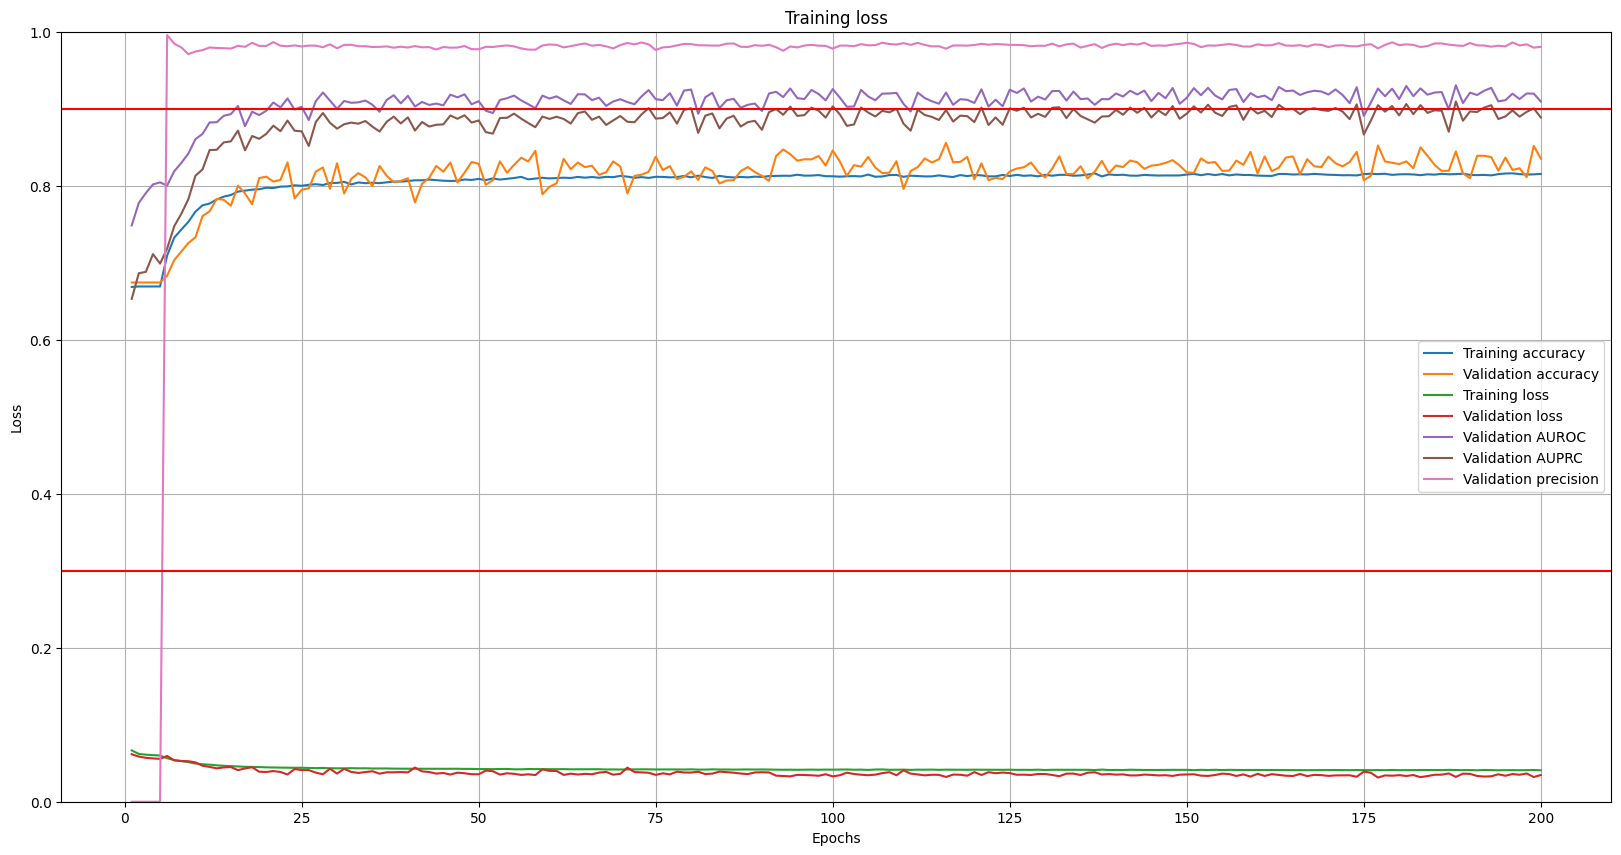

In [14]:
# Plot the training and validation loss and accuracy for each epoch for 4s partitions
with open('history_GAT.jason','r') as f:
    history_1 = pd.read_json(f)

training_accuracy = history_1['accuracy']
val_accuracy=history_1['val_accuracy']
training_loss = history_1['loss']
val_loss=history_1['val_loss']
val_AUROC=history_1['val_AUROC']
val_AUPRC=history_1['val_AUPRC']
val_precision=history_1['val_precision']
epochs = range(1, len(training_accuracy) + 1)

# Plot training loss against epochs
plt.figure(figsize=(20, 10))
plt.plot(epochs, training_accuracy, label='Training accuracy')
plt.plot(epochs, val_accuracy, label='Validation accuracy')
plt.plot(epochs, training_loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.plot(epochs, val_AUROC, label='Validation AUROC')
plt.plot(epochs, val_AUPRC, label='Validation AUPRC')
plt.plot(epochs, val_precision, label='Validation precision')

plt.axhline(y=0.3, color='r', linestyle='-')

plt.axhline(y=0.9, color='r', linestyle='-')
plt.grid()
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim([0, 1])    
plt.legend()
plt.show()